## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

### A note on variation of output

Note as always that due to the use of random numbers, some of the results here may differ from those in the book (since I re-ran everything to prepare this notebook), and will probably be different yet again if you run this notebook.

## Chapter 18: Autoencoders - Notebook 1: Small Models

Some code inspired or based on:
    
-    https://blog.keras.io/building-autoencoders-in-keras.html
-    https://jmetzen.github.io/2015-11-27/vae.html
-    https://arxiv.org/pdf/1606.05908.pdf  (https://github.com/cdoersch/vae_tutorial)

In [1]:
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Convolution2D, Dense, Input, MaxPooling2D, UpSampling2D
# import np_utils
from keras.datasets import mnist

import numpy as np
import h5py
import cv2

from keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

In [2]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
# make the tiny autoencoder in the text
def make_model(X):
    model = Sequential()
    model.add(Dense(20, input_shape=[len(X[0])], activation='relu'))
    model.add(Dense(len(X[0])))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [5]:
# A bunch of images to train on
images_list = ['tiger-bw-100', 
         'meter', 'teapot', 'creature', 'toothbrush', 'stairs', 'spigot', 'stones', 
         'upipe', 'lavender', 'ground', 'pavement', 'lawnmowers', 'manholecover', 'stick1', 
         'stick2', 'pinecone', 'cookies', 'bark', 'granite', 'blurrytree', 'tree', 
         'metalgrid', 'bushes', 'shed', 'hose']

In [6]:
# Get an image (or images) from the disk. If do_rotations is True,
# augment the data by rotating each image by 90, 180, and 270 degrees.

image_side = 100

def get_X(images, do_rotations=True):
    X = []
    for img_name in images:
        filepath = file_helper.get_input_file_path(img_name+'.jpg')
        im = cv2.resize(cv2.imread(filepath), (image_side, image_side)).astype(np.float32)
        im = cv2.cvtColor( im, cv2.COLOR_RGB2GRAY )
        if do_rotations:
            rows,cols = im.shape
            for angle in [0, 90, 180, 270]:
                M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
                im2 = cv2.warpAffine(im,M,(cols,rows))
                flat_im2 = np.ravel(im2/255.0)
                X.append(flat_im2)
        else: 
            flat_im = np.ravel(im/255.0)
            X.append(flat_im)
                
    num_images = len(images)
    if do_rotations:
        num_images *= 4
    X = np.reshape(X, (num_images, len(X[0])))
    return X

In [7]:
# predict an output images, show it, and save it
def predict_and_show(X, filename):
    pred_X = np.reshape(X[0], (1, len(X[0])))
    prediction = model.predict(pred_X, batch_size=1)[0]

    plt.subplot(1,2,1)
    plt.imshow(X[0].reshape(image_side, image_side), cmap="gray")
    plt.xticks([],[])
    plt.yticks([],[])
    plt.subplot(1,2,2)
    plt.imshow(prediction.reshape(image_side, image_side), cmap="gray")
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure(filename)
    plt.show()

In [8]:
def predict_and_show_with_errorbar(model, input_X, compare_X, filename):
    # It's tricky to get the colorbar in the right place.
    # Code based on https://matplotlib.org/examples/pylab_examples/custom_cmap.html
    pred_X = np.reshape(input_X[0], (1, len(input_X[0])))
    prediction = model.predict(pred_X, batch_size=1)[0]
    compare_flat = np.reshape(compare_X[0], len(compare_X[0]))
    diff = np.zeros((image_side, image_side))
    for y in range(image_side):
        for x in range(image_side):
            index = (y * image_side) + x
            diff[y,x] = compare_flat[index] - prediction[index]

    fig, axs = plt.subplots(1, 3, figsize=(10,3))
    fig.subplots_adjust(left=0.02, bottom=0.13, right=0.95, top=0.94, wspace=0.05)
    axs[0].imshow(pred_X.reshape(image_side, image_side), cmap="gray")
    axs[0].get_xaxis().set_visible(False)
    axs[0].get_yaxis().set_visible(False)
    axs[1].imshow(prediction.reshape(image_side, image_side), cmap="gray")
    axs[1].get_xaxis().set_visible(False)
    axs[1].get_yaxis().set_visible(False)
    cf = axs[2].imshow(diff.reshape(image_side, image_side), cmap="seismic")
    fig.colorbar(cf, ax=axs[2])
    axs[2].get_xaxis().set_visible(False)
    axs[2].get_yaxis().set_visible(False)

    file_helper.save_figure(filename)
    plt.show()

In [9]:
# a little utility to show the training images
def show_images_list():
    # we know the list has 25 entries so we'll just hard-code a 5-by-5 grid
    for y in range(5):
        for x in range(5):
            img_name = images_list[1+(y*5)+x]    
            filepath = file_helper.get_input_file_path(img_name+'.jpg')
            im = cv2.resize(cv2.imread(filepath), (image_side, image_side)).astype(np.float32)
            im = cv2.cvtColor( im, cv2.COLOR_RGB2GRAY )
            plt.subplot(5, 5, 1+((y*5)+x))
            plt.imshow(im, cmap="gray")
            plt.xticks([],[])
            plt.yticks([],[])
    plt.tight_layout()
    file_helper.save_figure('NB1-tiny-AE-image-set')
    plt.show()

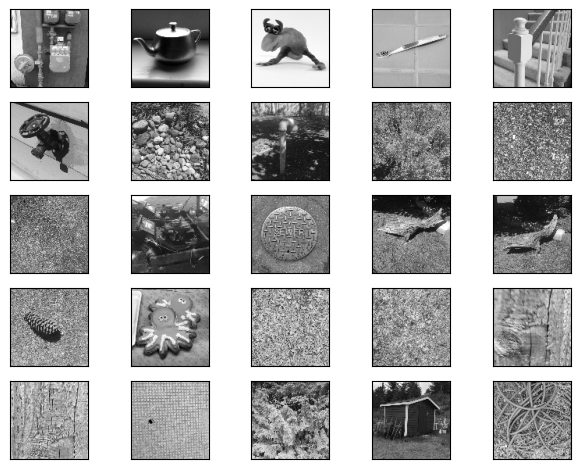

In [10]:
show_images_list()

In [11]:
def get_trained_model(training_data, weights_filename):
    # Train the tiny autoencoder on just the tiger and no other images
    model = make_model(training_data)
    np.random.seed(42)
    if not file_helper.load_model_weights(model, weights_filename):
        print("Training the model")
        model.fit(training_data, training_data, epochs=100, batch_size=128, verbose=0)
        file_helper.save_model_weights(model, weights_filename)
    return model

D:\CourseIAGenAI\git\iagenai\fmi-2025-04-deep-learning\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training the model
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


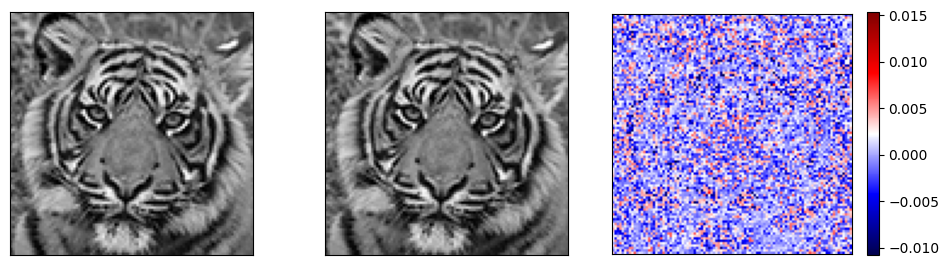

In [12]:
# Now give it the tiger as input, and show the predicted output
input_X = get_X(['tiger-bw-100'], False)
model = get_trained_model(input_X, 'NB1-tiny-AE-trained-on-tiger')
compare_X = get_X(['tiger-bw-100'], False)
predict_and_show_with_errorbar(model, input_X, compare_X, 
                               'NB1-tiny-AE-tiger-only-with-diffs')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


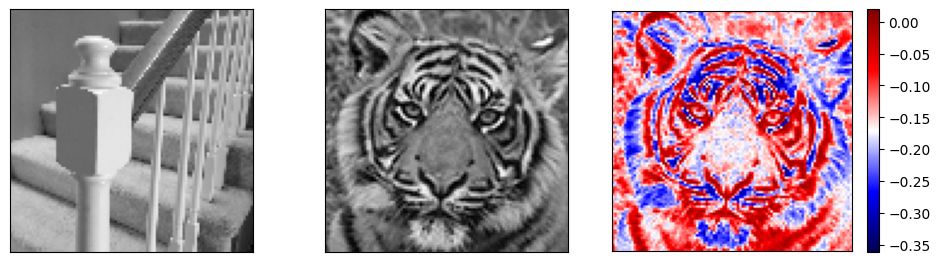

In [13]:
# Give the tiny AE *any* other picture as input. We always get the tiger.
input_X = get_X(['stairs'], False)
compare_X = get_X(['tiger-bw-100'], False)
predict_and_show_with_errorbar(model, input_X, compare_X, 
                               'NB1-tiny-AE-bannister-tiger-with-diffs')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


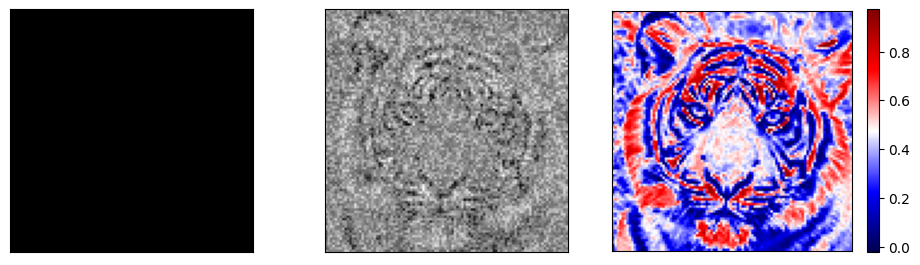

In [14]:
# How about an input where all pixels are 0?
input_X = np.zeros((1, 10000))
compare_X = get_X(['tiger-bw-100'], False)
predict_and_show_with_errorbar(model, input_X, compare_X, 
                               'NB1-tiny-AE-black-tiger-with-diffs')

In [15]:
# Let's try that again. Now train the tiny AE on the whole list of images.
input_X = get_X(images_list)
np.random.seed(42)
model = get_trained_model(input_X, 'NB1-tiny-AE-trained-on-image_set')

Training the model


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


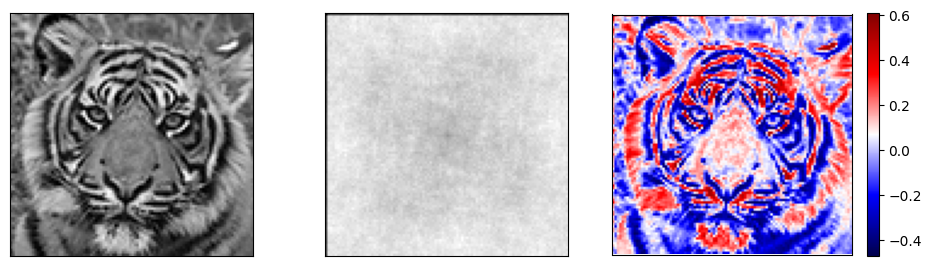

In [16]:
# And predict the tiger on this more generally-trained AE
input_X = get_X(['tiger-bw-100'], False)
compare_X = get_X(['tiger-bw-100'], False)
predict_and_show_with_errorbar(model, input_X, compare_X, 
                               'NB1-tiny-AE-all-images-with-diffs')